In [2]:
import importlib
import pickle
import functools
from pathlib import Path

import pandas as pd
import seaborn as sns
import numpy as np
from itertools import product

from mapra import prep

sns.set_theme(style='white')

In [3]:
importlib.reload(prep)

# the directory to search
wd = Path('.').resolve().parent
(wd / 'plots').mkdir(parents=True, exist_ok=True)

data = prep.dataset(wd)
df = data.dataframe
df.columns

/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:43: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)


Index(['UniProt_ID', 'MUTATION', 'pH', 'MEASURE', 'METHOD', 'MUT_COUNT',
       'DELTA', 'dtemp', 'ddg', 'h2o', 'DATASET', 'LENGTH', 'REPEATS'],
      dtype='object')

### extract embeddings for the SAVs from H5
the variants are labelled without the original residue here:
`P224R` in the dataframe becomes `224R` in the `.h5`.


### calculate paired distances for all embeddings

In [4]:
from sklearn.metrics.pairwise import paired_distances

## re-extract embedding data
extend = 0
mbed_file = data.read_mbeds(extend=extend)

reading /home/quirin/PYTHON/mapra/all_sequences_prothermdb_HALF.h5 ...
read 8113 embeddings for 323 proteins, each SAV with 0 neighbors on each side, wrote to /home/quirin/PYTHON/mapra/extracted_0.pkl


In [69]:
# fetch embedding data
mbeds = data.load_embeddings(mbed_file)

pdists = dict()
pairwise_metrics = ['euclidean', 'cosine', 'manhattan']

for uniprot_id, d in mbeds.items():
    wt = d.pop('wt')
    pdists[uniprot_id] = dict()
    for variant, ar in d.items():
        positions = [int(p[:-1]) - 1 for p in variant.split('_')]

        # extend to neighbourhood
        positions = sorted(set([c for ran in [list(range(
            max(0, p - extend), min(len(wt), p + extend + 1)))
            for p in positions] for c in ran]))

        pdists[uniprot_id][variant] = {m: sum(
            paired_distances(wt[positions, :], ar, metric=m)) for m in pairwise_metrics}
    d['wt'] = wt

### transfer paired distances to the dataframe
done: use different dataframes: `reduced=True`, remerged, repeats, gaussian
done: correlation ausrechnen
done: die anderen dataframes ausprobieren
done: die umgebung miteinbeziehen
done-ish: labels auf 0-1, 1-10, 10+


In [129]:
df = data.dataframe_abbrev(reduced=True)  # all records are their own line
# df = data.dataframe_remerged(reduced=True)
# df = data.dataframe_repeats_avg(reduced=True)
# df = data.dataframe_gaussian_avg(reduced=True)

mod = False
standard_scale = True
for m in pairwise_metrics:
    if mod == 'flip':
        df[m] = df.apply(lambda gdf: np.sign(gdf[gdf.DELTA]) * pdists.get(
            gdf.UniProt_ID, dict()).get(gdf.MUTATION, dict()).get(m, 0), axis=1)
    else:
        df[m] = df.apply(lambda gdf: pdists.get(
            gdf.UniProt_ID, dict()).get(gdf.MUTATION, dict()).get(m, 0), axis=1)
    if standard_scale:
        me, std = np.mean(df[m]), np.std(df[m])
        df[m] = df[m].apply(lambda f: (f - me) / std)
df

,UniProt_ID,MUTATION,pH,MEASURE,METHOD,MUT_COUNT,DELTA,dtemp,ddg,h2o,DATASET,LENGTH,REPEATS,euclidean,cosine,manhattan
0,A0A060GYS1,22R,7.5,fluorescence,Thermal,1,dtemp,9.9,NaN,NaN,reduced_set,333,1,-0.009086,-0.296307,0.006149
1,A0A060GYS1,224R,7.5,fluorescence,Thermal,1,dtemp,2.3,NaN,NaN,reduced_set,333,1,-0.471672,-0.270977,-0.486081
2,A0A410ZNC6,341S,7.5,Fluorescence,Thermal,1,dtemp,3.6,NaN,NaN,reduced_set,458,1,-0.682417,-0.775182,-0.678948
3,A0A410ZNC6,184L,7.5,Fluorescence,Thermal,1,dtemp,1.0,NaN,NaN,reduced_set,458,1,-0.669493,-0.728490,-0.653873
4,A0A410ZNC6,184L_250L_341S,7.5,Fluorescence,Thermal,3,dtemp,5.6,NaN,NaN,reduced_set,458,1,1.133641,0.686005,1.148791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14593,R9S082,15F,7.8,CD,Urea,1,h2o,NaN,NaN,-0.6,reduced_set,154,3,-0.641614,-0.678146,-0.665176
14594,R9S082,15F,7.8,CD,Urea,1,h2o,NaN,NaN,-1.1,reduced_set,154,3,-0.641614,-0.678146,-0.665176
14595,R9S082,8F,7.8,CD,Urea,1,h2o,NaN,NaN,-0.9,reduced_set,154,3,-0.569289,-0.696522,-0.586122
14596,R9S082,8F,7.8,CD,Urea,1,h2o,NaN,NaN,-1.1,reduced_set,154,3,-0.569289,-0.696522,-0.586122


### plot correlations

In [130]:
dfc = df.loc[:, data.order + pairwise_metrics].melt(
    id_vars=data.order, value_vars=pairwise_metrics,
    var_name='metric', value_name='dist').melt(
    id_vars=['metric', 'dist'], value_vars=data.order,
    var_name='delta', value_name='change')
dfc = dfc[~dfc.change.isna()].reset_index(drop=True)  # drop all the NaN lines. it's ok why they were there

if mod == 'abs':
    dfc.change = dfc.change.abs() # make all changes positive
elif mod == 'pos':
    dfc = dfc.loc[dfc.change > 0]
elif mod == 'neg':
    dfc = dfc.loc[dfc.change < 0]
dfc

,metric,dist,delta,change
0,euclidean,-0.009086,dtemp,9.9
1,euclidean,-0.471672,dtemp,2.3
2,euclidean,-0.682417,dtemp,3.6
3,euclidean,-0.669493,dtemp,1.0
4,euclidean,1.133641,dtemp,5.6
...,...,...,...,...
36238,manhattan,-0.665176,h2o,-0.6
36239,manhattan,-0.665176,h2o,-1.1
36240,manhattan,-0.586122,h2o,-0.9
36241,manhattan,-0.586122,h2o,-1.1


In [131]:
# calculate Pearson correlation coefficient
covs = dict()
for d, m in product(data.order, pairwise_metrics):
    covs[d, m] = np.corrcoef(
        dfc.loc[(dfc.delta == d) & (dfc.metric == m),
                ['dist', 'change']], rowvar=False)[0, 1]
covs


{('dtemp', 'euclidean'): 0.16195032927189107,
 ('dtemp', 'cosine'): 0.16024223782556093,
 ('dtemp', 'manhattan'): 0.15973707487478353,
 ('ddg', 'euclidean'): 0.10906135542063321,
 ('ddg', 'cosine'): 0.09028686357382613,
 ('ddg', 'manhattan'): 0.10643573206446927,
 ('h2o', 'euclidean'): 0.11461465982957277,
 ('h2o', 'cosine'): 0.14200168816527534,
 ('h2o', 'manhattan'): 0.11952469850165622}

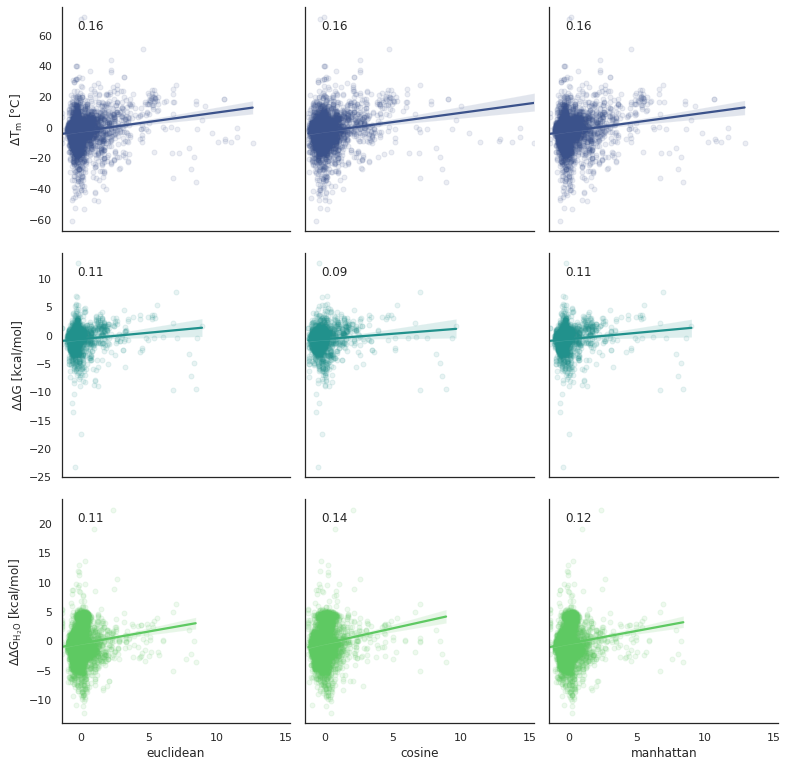

In [132]:
# create a plot
g = sns.lmplot(data=dfc,
               x='dist', y='change',
               hue='delta', palette='viridis',
               sharex=standard_scale, sharey='row',
               col='metric', col_order=pairwise_metrics,
               row='delta', row_order=data.order,
               scatter_kws={'s': 25, 'alpha': .1},
               height=3.6, aspect=1, ci=95, order=1,  #fit_reg=False,
               )

for (d, m), ax in g.axes_dict.items():
    # ax.axline((0,0), slope=1, color='.5', lw=.7)
    pearson_corr = np.corrcoef(dfc.loc[(dfc.delta == d) & (dfc.metric == m),
                                       ['dist', 'change']], rowvar=False)[0, 1]
    ax.text(.07, .9, f'{pearson_corr:.2f}', transform=ax.transAxes)
for i, ax in enumerate(g.axes[2,]):
    ax.set_xlabel(pairwise_metrics[i])
for i, ax in enumerate(g.axes[:, 0]):
    ax.set_ylabel(data.tex_lookup[data.order[i]] + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i])
    if not standard_scale:
        ax.set_xlim(-40 if mod else 0, 40)
if not standard_scale:
    for ax in g.axes[:, 1]:
        ax.set_xlim(-3 if mod else 0, 3)
    for ax in g.axes[:, 2]:
        ax.set_xlim(-1000 if mod else 0, 1000)
    for ax in g.axes.flatten()[:6]:
        ax.set_xticklabels([])
for ax in g.axes.flatten():
    ax.set_title('')
g.fig.subplots_adjust(hspace=.1)
g.savefig(wd / 'plots' / f'{extend}_neighbors_pearson_sum_{mod if mod else "none"}_ci95_standard_scale.png', dpi=300)

### train models
TODO: train models on `data.dataframe_remerged(reduced=True)`
then find out how to merge the `lm.coef_` and apply that to build a single compound model?

In [133]:
from sklearn import linear_model, metrics, preprocessing
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# help(train_test_split)
# help(lm.fit)
# help(linear_model.LogisticRegressionCV)

digits = load_digits()
digits.data  # an array 1797x64
digits.feature_names  # the pixel names
digits.target  # an array of len 1797 with the correct digit indices = the digits themselves
digits.target_names  # the names of the digits = the digits themselves
dir(digits)

['DESCR', 'data', 'feature_names', 'frame', 'images', 'target', 'target_names']

In [134]:
dfc

,metric,dist,delta,change
0,euclidean,-0.009086,dtemp,9.9
1,euclidean,-0.471672,dtemp,2.3
2,euclidean,-0.682417,dtemp,3.6
3,euclidean,-0.669493,dtemp,1.0
4,euclidean,1.133641,dtemp,5.6
...,...,...,...,...
36238,manhattan,-0.665176,h2o,-0.6
36239,manhattan,-0.665176,h2o,-1.1
36240,manhattan,-0.586122,h2o,-0.9
36241,manhattan,-0.586122,h2o,-1.1


### convert labels to integers + split into training + test data

In [135]:
dfi = dfc.copy(deep=True)
dfi.delta = dfi.delta.apply(data.order.index)
dfi.metric = dfi.metric.apply(pairwise_metrics.index)
dfi

,metric,dist,delta,change
0,0,-0.009086,0,9.9
1,0,-0.471672,0,2.3
2,0,-0.682417,0,3.6
3,0,-0.669493,0,1.0
4,0,1.133641,0,5.6
...,...,...,...,...
36238,2,-0.665176,2,-0.6
36239,2,-0.665176,2,-1.1
36240,2,-0.586122,2,-0.9
36241,2,-0.586122,2,-1.1


In [136]:
# use only the euclidean distance
dft = dfi.loc[(dfi.metric == 0)]  # & (dfi.delta == 0)]
x_train, y_train = dft[['delta', 'dist']], dft['change']
x_train, y_train

(       delta      dist
 0          0 -0.009086
 1          0 -0.471672
 2          0 -0.682417
 3          0 -0.669493
 4          0  1.133641
 ...      ...       ...
 26158      2 -0.641614
 26159      2 -0.641614
 26160      2 -0.569289
 26161      2 -0.569289
 26162      2 -0.569289
 
 [12081 rows x 2 columns],
 0        9.9
 1        2.3
 2        3.6
 3        1.0
 4        5.6
         ... 
 26158   -0.6
 26159   -1.1
 26160   -0.9
 26161   -1.1
 26162    0.1
 Name: change, Length: 12081, dtype: float64)

In [137]:
# # old way for all three pairwise metrics
# x_train, y_train = dfi[['delta', 'metric', 'dist']], dfi['change']

# and convert changes to discrete classes
# y_train = y_train.apply(lambda f: '--' if f < -10 else '-' if f < -1 else '=' if f < 1 else '+' if f < 10 else '++')
# y_train = y_train.apply(lambda f: -1 if f <= -1 else 0 if f <= 1 else 1)
# y_train = y_train.apply(lambda f: -1 if f <= 0 else 1)
y_train = y_train.apply(lambda f: 0 if abs(f) <= 1 else 1)
y_train

0        1
1        1
2        1
3        0
4        1
        ..
26158    0
26159    1
26160    0
26161    1
26162    0
Name: change, Length: 12081, dtype: int64

In [138]:
# split into test and training data
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=0.25, random_state=0)
x_train, x_test, y_train, y_test


(       delta      dist
 32         0 -0.636883
 24614      2 -0.660266
 1617       0  1.243059
 4209       0 -0.507603
 1279       0 -0.473655
 ...      ...       ...
 4859       0 -0.122711
 3264       0  9.081008
 23927      2  0.302592
 24881      2 -0.263874
 2732       0 -0.546610
 
 [9060 rows x 2 columns],
        delta      dist
 25165      2  1.225966
 16183      1  0.064114
 24240      2  0.253298
 25008      2 -0.391663
 134        0 -0.201633
 ...      ...       ...
 15         0 -0.470863
 21647      2  0.200985
 22744      2 -0.503380
 25149      2 -0.642799
 22411      2 -0.577164
 
 [3021 rows x 2 columns],
 32       0
 24614    1
 1617     1
 4209     0
 1279     1
         ..
 4859     0
 3264     1
 23927    0
 24881    1
 2732     1
 Name: change, Length: 9060, dtype: int64,
 25165    1
 16183    1
 24240    1
 25008    1
 134      1
         ..
 15       1
 21647    0
 22744    1
 25149    0
 22411    0
 Name: change, Length: 3021, dtype: int64)

In [139]:
# fit the model
lm = linear_model.LogisticRegressionCV(max_iter=300, cv=5)
lm.fit(x_train, y_train)
lm.coef_

array([[-0.03868698,  0.04483767]])

In [140]:
# # make our test data look like real data -> no sign in front of the dist
# x_test.dist = x_test.dist.apply(abs)
# y_test = y_test.apply(abs)
# x_test, y_test

In [141]:
# make a prediction
predictions = lm.predict(x_test)
acc = lm.score(x_test, y_test)
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)
print(acc)

[[   0 1014]
 [   0 2007]]
0.6643495531281033


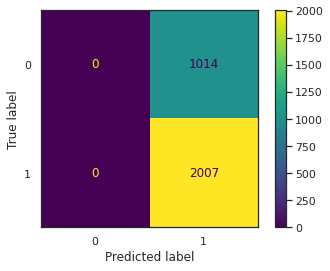

In [142]:
metrics.ConfusionMatrixDisplay(cm).plot()